# Рекомендация тарифов

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Открытие-и-изучение-файла" data-toc-modified-id="Открытие-и-изучение-файла-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Открытие и изучение файла</a></span></li><li><span><a href="#Разделение-данных-на-выборки" data-toc-modified-id="Разделение-данных-на-выборки-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Разделение данных на выборки</a></span></li><li><span><a href="#Исследование-моделей" data-toc-modified-id="Исследование-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Исследование моделей</a></span></li><li><span><a href="#Проверка-модели-на-тестовой-выборке" data-toc-modified-id="Проверка-модели-на-тестовой-выборке-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Проверка модели на тестовой выборке</a></span></li><li><span><a href="#Проверка-модели-на-адекватность" data-toc-modified-id="Проверка-модели-на-адекватность-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Проверка модели на адекватность</a></span></li></ul></div>

## Описание проекта

Оператор мобильной связи выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нам нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных уже была проведена ранее.

Цель проекта — построить модель с максимально большим значением *accuracy* (минимум — 0.75).

In [1]:
# импоортируем библиотеки
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier

import matplotlib.pyplot as plt

## Открытие и изучение файла

Откроем файл с данными и изучим его.

In [2]:
try:
    df = pd.read_csv('users_behavior.csv')
except:
    df = pd.read_csv('/datasets/users_behavior.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [3]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


Взглянем на распределения данных.

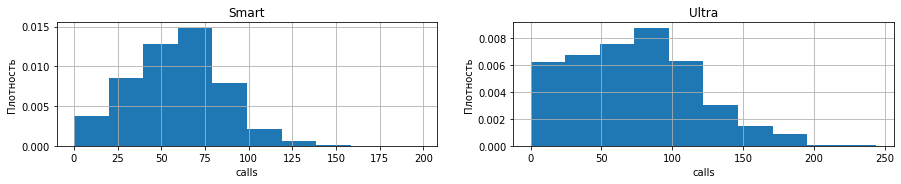

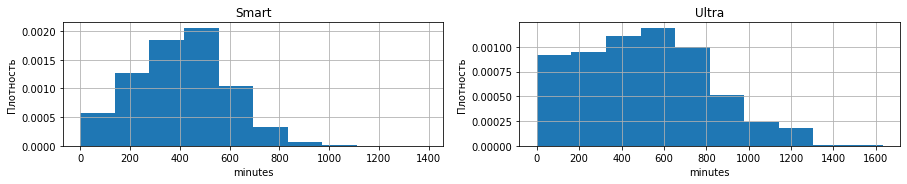

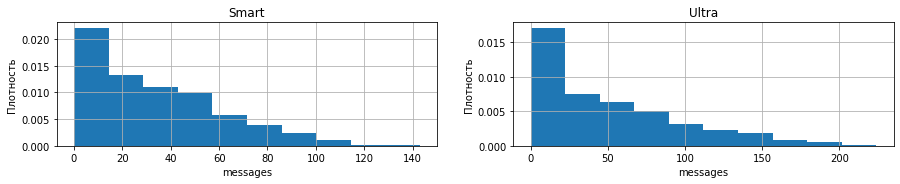

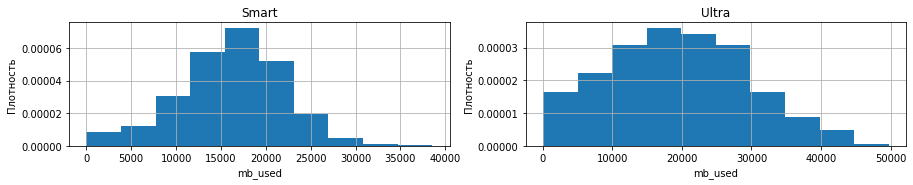

In [4]:
for column in df.drop('is_ultra', axis=1).columns:
    smart = df[df['is_ultra'] == 0]
    ultra = df[df['is_ultra'] == 1]
    fig, ax = plt.subplots(figsize=(15, 5))
    plt.subplot(2, 2, 1, title='Smart', xlabel=column, ylabel='Плотность')
    smart[column].hist(density=True)
    plt.subplot(2, 2, 2, title='Ultra', xlabel=column, ylabel='Плотность')
    ultra[column].hist(density=True)
    plt.show()

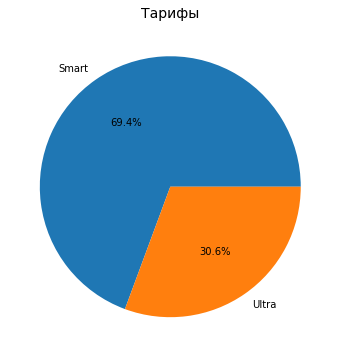

In [5]:
pie, ax = plt.subplots(figsize=[10,6])
labels = ['Smart', 'Ultra']
plt.pie(x=df.groupby('is_ultra')['is_ultra'].count(), labels=labels, autopct="%.1f%%")
plt.title("Тарифы", fontsize=14);

В нашем распоряжении датасет на 3214 строки, пропусков и выбросов нет — все они были ранее обработаны. Дисперсия в данных тарифа Ultra чуть больше, как и средние показатели потребляемого трафика. Также видим, что распределение классов не равно: пользователей на тарифе Smart больше, чем на тарифе Ultra в 2 с лишним раза.

## Разделение данных на выборки

Для дальнейшего анализа нам необходимо разделить исходные данные на обучающую, валидационную и тестовую выборки. Начнем с того, что разделим датасет на фичи и целевой признак — тариф.

In [6]:
features = df.drop('is_ultra', axis=1)
target = df['is_ultra']

features.shape

(3214, 4)

У нас получился датасет на 3214 строки и 4 стобца, тариф мы вывели в отдельный столбец, так как собираемся его предсказывать. Далее разделим датасет на тренировочные и валидационные данные. Поделим набор в соотношении 3:1:1, чтобы данные для обучения составляли 60%, а остальные 40 приходились на валидационную и тестовую выборку — по 20 на каждую. Также не забудем установить условие, что данные должны разбиваться с тем же соотношением классов, что и в оригинальном датасете, поскольку распределение классов у нас не сбалансированное.

In [7]:
X_train, X_valid_test, y_train, y_valid_test = train_test_split(
                                                features, target, test_size=0.40, random_state=42, stratify=target)

In [8]:
print('Размеры обучающей выборки:', X_train.shape)

Размеры обучающей выборки: (1928, 4)


Мы получили две выборки, и теперь вторую нам нужно разделить еще пополам, чтобы получить две отдельные выборки — валидационную и тестовую. Действуем по аналогии с предыдущим делением, но делим данные пополам.

In [9]:
X_test, X_valid, y_test, y_valid = train_test_split(
                                        X_valid_test, y_valid_test, test_size=0.50, random_state=42, stratify=y_valid_test)

In [10]:
print('Размеры валидационной выборки:', X_valid.shape)
print('Размеры тестовой выборки:', X_test.shape)

Размеры валидационной выборки: (643, 4)
Размеры тестовой выборки: (643, 4)


На этом шаге мы разделили датасет на три выборки — обучающую, валидационную и тестовую, выбрав для них соотношение 60/20/20. При разделении мы сохранили классовое распределение оригинального датасета для каждой из выборок.

## Исследование моделей

Следующим шагом исследуем качество предсказания разных моделей и выберем наиболее подходящие гиперпараметры для нашей выборки.
Начнем исследование с модели Решающего дерева. Для оценки результата классификации будем использовать критерий accuracy.

In [11]:
best_tree_accuracy = 0
best_tree = None
for depth in range(1,11):
    tree = DecisionTreeClassifier(random_state=42, max_depth=depth)
    tree.fit(X_train, y_train) # обучаем модель
    tree_prediction = tree.predict(X_valid) # предсказываем значения валидационной выборки
    tree_accuracy = accuracy_score(y_valid, tree_prediction) # смотрим процент угаданных значений
    if tree_accuracy > best_tree_accuracy:
        best_tree_accuracy = tree_accuracy
        best_tree = tree # здесь хранится лучшая модель
print('Лучшая модель:', best_tree)
print('Лучший результат:', best_tree_accuracy)

Лучшая модель: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')
Лучший результат: 0.7947122861586314


Далее посмотрим, как на этих данных отработает Случайный лес. Будем менять глубину и количество деревьев.

In [12]:
best_forest_accuracy = 0
best_forest = None
for depth in range(1,11):
    for n_est in range(1,50,5):
        forest = RandomForestClassifier(random_state=42, max_depth=depth, n_estimators=n_est)
        forest.fit(X_train, y_train)
        forest_prediction = forest.predict(X_valid)
        forest_accuracy = accuracy_score(y_valid, forest_prediction)
        if forest_accuracy > best_forest_accuracy:
            best_forest_accuracy = forest_accuracy
            best_forest = forest
print('Лучшая модель:', best_forest)
print('Лучший результат:', best_forest_accuracy)

Лучшая модель: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=8, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=36,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Лучший результат: 0.8164852255054432


Последняя модель, которую мы рассмотрим — логистическая регрессия. В ней гиперпараметры менять не будем.

In [13]:
logreg = LogisticRegression(random_state=42, solver='liblinear', penalty='l1')
logreg.fit(X_train, y_train)
logreg_prediction = logreg.predict(X_valid)
logreg_accuracy = accuracy_score(y_valid, logreg_prediction)

print('Результат:', logreg_accuracy)

Результат: 0.7309486780715396


По результатам исследования работы трех моделей с разными гиперпараметрами, наилучший результат (свыше 81%) был получен моделью Случайный лес с глубиной 8 и 36 эстиматорами. Наименее удачный результат показала модель Логистическая регрессия — 73%.

У дерева и леса результаты достаточно близки, как и гиперпараметры, показавшие лучшие результаты — для дерева это глубина 7, а для леса 8. Лес справился лучше, поскольку в нем использовано ансамбль тех же деревьев, однако такая глубина и немалое количество эстиматоров может привести к переобучению. Проверим это предположение на тестовой выборке.

## Проверка модели на тестовой выборке

Теперь проверим качество выбранной нам модели на ранее полученной тестовой выборке.

In [14]:
forest_prediction_test = best_forest.predict(X_test)
forest_accuracy = accuracy_score(y_test, forest_prediction_test)

forest_accuracy

0.8009331259720062

Итак, мы получили accuracy для тестовой выборки, равное 80%, что немного меньше, чем на валидационной. Это может говорить о переобучении, хоть и небольшом. В целом, поставленной цели мы добились и получили accuracy выше 75%. 

## Проверка модели на адекватность

Теперь проверим рассмотреные нами модели на вменяемость. Вдруг любая случайная модель даст результат не хуже полученного нами? Для проверки рассмотрим модель DummyClassifier.

In [15]:
dummy_clf = DummyClassifier(random_state=42, strategy='stratified')
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_test, y_test)

0.578538102643857

Как видим, случайная модель дает результат 57,8%, а это существенно ниже, чем все полученные нами результаты, поэтому рассмотренные модели можно считать адекватными.

В ходе анализа мы выяснили, что лучшие предсказания на нашем датасете делает модель Случайный лес — она дает не менее 80% правильных ответов. Чуть хуже результат у Решающего дерева (ок. 79%), а самый низкий показатель — у Логистической регрессии (73%). Тем не менее, все модели показали результат лучше, чем случайная модель DummyClassifier(ок. 58%). В нашем анализе при обучении Случайного леса были рассмотрены разные значения гиперпараметров max_depth и n_estimators, а для дальнейшего улучшения оценки модели можно поэкспериментировать с другими гиперпараметрами.